In [1]:
!pip install numpy matplotlib requests
!pip install torch torchvision torchaudio

Looking in indexes: https://download.pytorch.org/whl/cu126


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import requests

In [3]:
link = 'https://github.com/Vanya119/mdl/raw/refs/heads/main/instructions_preparations.txt'

response = requests.get(link)
file_content = response.text

In [5]:
words = []

file_rows = file_content.replace('\ufeff','').split('\r\n')
file_text = file_content.replace('\ufeff','').replace('\r\n', ' ')

for row in file_rows:
    for word in row.split(' '): words.append(word)
file_rows[:20]

["Парацетамол обладает анальгезирующим, жаропонижающим и крайне слабым противовоспалительным действием, что связано с его влиянием на центр терморегуляции в гипоталамусе и слабовыраженной способностью ингибировать синтез простагландинов в периферических тканях. \n\nОтсутствие блокирующего влияния на синтез простагландинов в периферических тканях обусловливает отсутствие у него отрицательного влияния на водно-солевой обмен (задержка ионов натрия и воды) и слизистую оболочку желудочно-кишечного тракта.\n\rАбсорбция высокая, препарат быстро и практически полностью всасывается из желудочно-кишечного тракта. Связь с белками плазмы около 15%. \nПик концентрации в плазме достигается через 30-60 минут.\n\rПроникает через гематоэнцефалический барьер. Менее 1% от принятой кормящей матерью дозы парацетамола проникает в грудное молоко. \n\nТерапевтическая эффективная концентрация парацетамола в плазме достигается при его назначении в дозе 10-15 мг/кг.\n\rМетаболизируется в печени (90-95%): 80% вст

In [7]:
file_content = response.text.replace('\ufeff', '')

file_rows = [row for row in file_content.splitlines() if row.strip()]

smiles = []

for row in file_rows:
    parts = row.split()
    if not parts:
        continue
    smi = parts[0]
    smiles.append(smi)
smiles[:20]

['Парацетамол',
 'Отсутствие',
 'Абсорбция',
 'Пик',
 'Проникает',
 'Терапевтическая',
 'Метаболизируется',
 'При',
 'В',
 'Выводится',
 'Дополнительными',
 'У',
 'Жаропонижающее',
 'Обезболивающее',
 'Внутрь,',
 'Взрослым',
 'Детям',
 'Максимальная',
 'Максимальная',
 'У']

In [8]:
all_chars = sorted(list(set(file_text)))

special_tokens = ['<PAD>', '<BOS>', '<EOS>']
all_chars = special_tokens + all_chars

char_to_ix = {char: i for i, char in enumerate(all_chars)}
ix_to_char = {i: char for i, char in enumerate(all_chars)}

max_len = max(map(len, file_rows)) + 2

vocab_size = len(all_chars)
print(f"Размер словаря: {vocab_size}")
print("Пример словаря 'char_to_ix':", {k: v for i, (k, v) in enumerate(char_to_ix.items()) if i < 10})

Размер словаря: 129
Пример словаря 'char_to_ix': {'<PAD>': 0, '<BOS>': 1, '<EOS>': 2, '\n': 3, '\r': 4, ' ': 5, '!': 6, '#': 7, '%': 8, '&': 9}


In [9]:
def to_matrix(file_rows, max_len=max_len):
    matrix = torch.full((len(file_rows), max_len), char_to_ix['<PAD>'], dtype=torch.long)

    for i, row in enumerate(file_rows):
        ixs = [char_to_ix['<BOS>']] + [char_to_ix[char] for char in row] + [char_to_ix['<EOS>']]
        matrix[i, :len(ixs)] = torch.tensor(ixs, dtype=torch.long)

    return matrix

def to_idx(text):
    vect = [char_to_ix['<BOS>']]
    for i in range(len(text)): vect.append(char_to_ix[text[i]])
    return vect

rows_ix = to_matrix(file_rows)
print(f"Пример тензора для строки {file_rows[0]}:")
print(rows_ix[0])
print("Размерность матрицы:", rows_ix.size())

Пример тензора для строки Парацетамол обладает анальгезирующим, жаропонижающим и крайне слабым противовоспалительным действием, что связано с его влиянием на центр терморегуляции в гипоталамусе и слабовыраженной способностью ингибировать синтез простагландинов в периферических тканях. :
tensor([  1,  83,  93, 109,  93, 115,  98, 111,  93, 105, 107, 104,   5, 107,
         94, 104,  93,  97,  93,  98, 111,   5,  93, 106,  93, 104, 121,  96,
         98, 100, 101, 109, 112, 123, 118, 101, 105,  14,   5,  99,  93, 109,
        107, 108, 107, 106, 101,  99,  93, 123, 118, 101, 105,   5, 101,   5,
        103, 109,  93, 102, 106,  98,   5, 110, 104,  93,  94, 120, 105,   5,
        108, 109, 107, 111, 101,  95, 107,  95, 107, 110, 108,  93, 104, 101,
        111,  98, 104, 121, 106, 120, 105,   5,  97,  98, 102, 110, 111,  95,
        101,  98, 105,  14,   5, 116, 111, 107,   5, 110,  95, 124, 100,  93,
        106, 107,   5, 110,   5,  98,  96, 107,   5,  95, 104, 101, 124, 106,
        10

In [10]:
class RNNmodel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.rnn_update_2 = nn.Linear(hidden_size, hidden_size)
        self.rnn_update_3 = nn.Linear(hidden_size, hidden_size)
        self.rnn_to_logits = nn.Linear(hidden_size, vocab_size)

    def forward(self, x_t, h_t_prev):
        x_t_emb = self.embedding(x_t)
        x_and_h = torch.cat([x_t_emb, h_t_prev], dim=1)
        h_t_new = torch.tanh(self.rnn_update(x_and_h))
        h_t_new_2 = torch.tanh(self.rnn_update_2(h_t_new))
        h_t_new_3 = torch.tanh(self.rnn_update_3(h_t_new_2))

        logits = self.rnn_to_logits(h_t_new_3)
        return h_t_new_3, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [11]:
vocab_size = len(all_chars)
embedding_size = 64
hidden_size = 512
learning_rate = 0.0025
num_epochs = 40
batch_size = 32

char_rnn = RNNmodel(vocab_size, embedding_size, hidden_size)

first_batch = rows_ix[:batch_size]
hid_state = char_rnn.initial_state(batch_size)
first_input = first_batch[:, 0]
new_hid_state, logits = char_rnn(first_input, hid_state)

optimizer = optim.Adam(char_rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=char_to_ix['<PAD>'])

dataset = torch.utils.data.TensorDataset(rows_ix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)
        logprobs.append(F.log_softmax(logits, -1))
    return torch.stack(logprobs, dim=1)

logprobs = rnn_loop(char_rnn, first_batch)
print("Размерность итогового тензора logprobs:", logprobs.size())

Размерность итогового тензора logprobs: torch.Size([32, 813, 129])


In [13]:
loss_history = []
clip_value = 1.0

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dataloader:
        batch_ix = batch[0]
        x = batch_ix[:, :-1]
        y = batch_ix[:, 1:]
        optimizer.zero_grad()
        logprobs = rnn_loop(char_rnn, x)
        loss = criterion(logprobs.transpose(1, 2), y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(char_rnn.parameters(), clip_value)
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 2 == 0:
        print(f"Эпоха {epoch+1}/{num_epochs}, Средняя потеря: {avg_loss:.4f}")

Эпоха 2/40, Средняя потеря: 3.0453
Эпоха 4/40, Средняя потеря: 2.8051
Эпоха 6/40, Средняя потеря: 2.5906
Эпоха 8/40, Средняя потеря: 2.4575
Эпоха 10/40, Средняя потеря: 2.2962
Эпоха 12/40, Средняя потеря: 2.1593
Эпоха 14/40, Средняя потеря: 2.0501
Эпоха 16/40, Средняя потеря: 1.9397
Эпоха 18/40, Средняя потеря: 1.8475
Эпоха 20/40, Средняя потеря: 1.8042
Эпоха 22/40, Средняя потеря: 1.7155
Эпоха 24/40, Средняя потеря: 1.6020
Эпоха 26/40, Средняя потеря: 1.5481
Эпоха 28/40, Средняя потеря: 1.4903
Эпоха 30/40, Средняя потеря: 1.4113
Эпоха 32/40, Средняя потеря: 1.3689
Эпоха 34/40, Средняя потеря: 1.3293
Эпоха 36/40, Средняя потеря: 1.2697
Эпоха 38/40, Средняя потеря: 1.2343
Эпоха 40/40, Средняя потеря: 1.1896


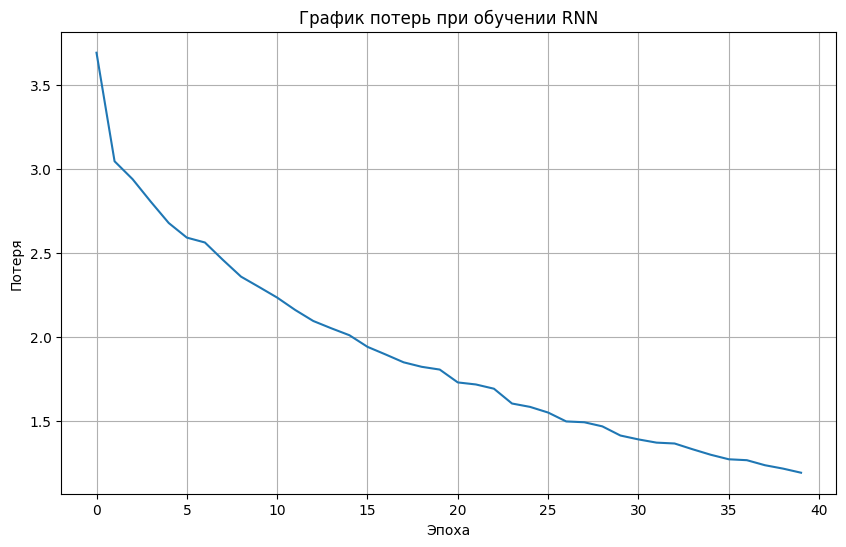

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('График потерь при обучении RNN')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.grid(True)
plt.show()

In [16]:
def generate_name(char_rnn, max_length=max_len, temperature=1.0, start_text=None):
    char_rnn.eval()

    with torch.no_grad():
        hid_state = char_rnn.initial_state(batch_size=1)

        if start_text:
            start_indices = to_idx(start_text)
            current_char_ix = None
            for char_index in start_indices:
                current_char_ix = torch.tensor([char_index], dtype=torch.long)
                hid_state, _ = char_rnn(current_char_ix, hid_state)
        else:
            current_char_ix = torch.tensor([char_to_ix['<BOS>']], dtype=torch.long)

        generated_chars = []

        for _ in range(max_length):
            hid_state, logits = char_rnn(current_char_ix, hid_state)

            logits = logits / temperature
            probs = F.softmax(logits, dim=1).squeeze()

            current_char_ix = torch.multinomial(probs, 1)

            if current_char_ix.item() == char_to_ix['<EOS>']:
                break

            generated_chars.append(ix_to_char[current_char_ix.item()])

    if start_text:
        return start_text + ''.join(generated_chars)
    else:
        return ''.join(generated_chars)

print("**Примеры генерации:**\n")
for _ in range(1):
    print(generate_name(char_rnn, temperature=0.7))

**Примеры генерации:**

При применяют раствор у взрослых - 1000 мг, гипотанамино в крови и тербирующего фозга, беременности в сутки сводимости и составляет снижение соврена лимфалгия, антиде, комбияния глутатом, настрасте, препарата и вызывают в снижает внутрь и выраженный антидепровотической заболевания от миновыми активные слабым доза дозворного содержания дозы с барацетилсалициловая которые внутривенное раздражение кразование является в одновременные антидов после нарушение приеме на центральным бетилсалициловая кислота и нарушение и действие или дозы - 20 г инкугации детям отирморетическом в концентрации для большых противоводая необходимо отека действия и трему. Через 3 ч дозы.


In [40]:
for _ in range(1):
    print(generate_name(char_rnn, temperature=0.7,max_length=150, start_text='Побочные действия'))

Побочные действия в стороны с белками и дозы или рекомендуется повышает 88 или в концентрации в кишечное доза период образом приёме бывержание проникает диарея и охышу


In [36]:
for _ in range(1):
    print(generate_name(char_rnn, max_length=200, start_text='Действия парацетамол', temperature=0.7))

Действия парацетамола синдроме которые активается в сенетоматическое средной уменьшения с дозы - вызывать 1 лет (глокармин - 0,00 мг, таким детем и острого действием не метаболизирующим ходы) острая больными введение кист


In [106]:
for _ in range(2):
    print(generate_name(char_rnn, temperature=0.7, max_length=180))
    print()

Больно грудность, которые выводится снижение препарата (1-1 мг, части носовов с очень развитическом приступальным провестального проведенной доза повышает метаболизме. Несидроксина

При тяжелой кислота и применение зависит лабость сопровождающийся снижает с из применять проведение как прием препарат принимать сыворотка - 10% и давления действие канальгина, мол

